# RNN Time Series 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

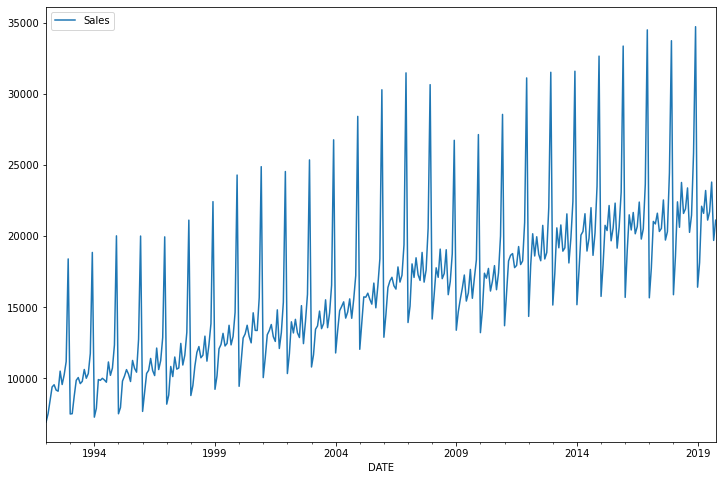

In [5]:
df.plot(figsize=(12,8))

## Train Test Split

In [6]:
len(df)

334

In [7]:
len(df)- 18

316

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
n_features = 1

In [21]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [26]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0276 - val_loss: 0.0737
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0179 - val_loss: 0.0063
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 4.7443e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0077
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0021 - val_loss: 4.8042e-04


In [27]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

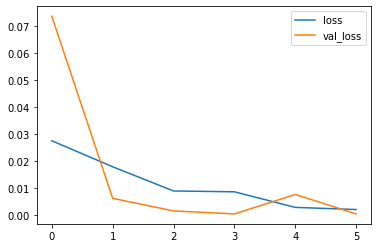

In [28]:
losses.plot()

## Evaluate on Test Data

In [29]:
first_eval_batch = scaled_train[-length:]

In [31]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [32]:
model.predict(first_eval_batch)

array([[0.502804]], dtype=float32)

In [33]:
scaled_test[0]

array([0.61087714])

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

<ipython-input-36-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [37]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,20787.232861
2018-06-01,21589,19703.066908
2018-07-01,21919,19896.280401
2018-08-01,23381,21600.199718
2018-09-01,20260,19215.528624
2018-10-01,21473,19731.401877
2018-11-01,25831,23538.904929
2018-12-01,34706,34300.688376
2019-01-01,16410,15856.659299


<AxesSubplot:xlabel='DATE'>

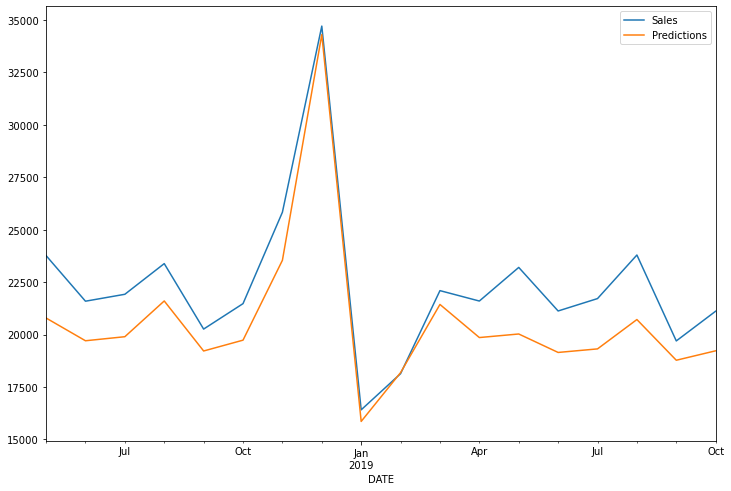

In [38]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [39]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [40]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [41]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0289
Epoch 2/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0164
Epoch 3/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0110
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0073
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0044
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0016


In [42]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [43]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [44]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [45]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [46]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [47]:
forecast_df

,Forecast
2019-11-01,25970.681943
2019-12-01,36510.697756
2020-01-01,17220.493317
2020-02-01,18821.793387
2020-03-01,22081.138986
2020-04-01,21726.072716
2020-05-01,23151.341852
2020-06-01,21414.028513
2020-07-01,21970.562176
2020-08-01,23817.124149


<AxesSubplot:>

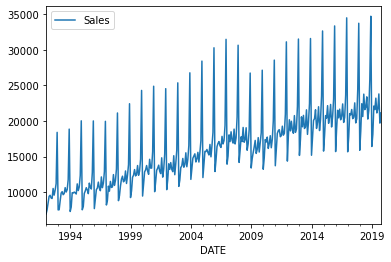

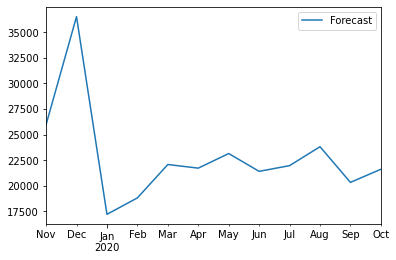

In [48]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

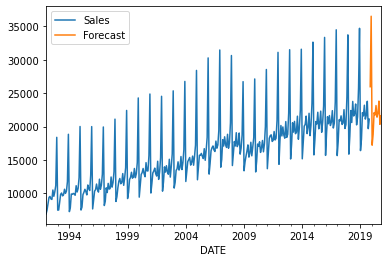

In [49]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

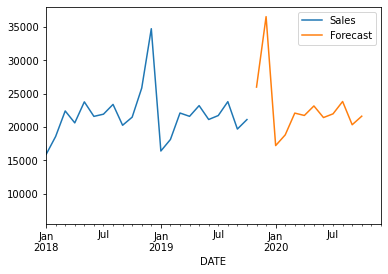

In [50]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')